## Notebook for team 4

### Create virtual environment
In terminal, command prompt (Menu: Terminal > New Terminal > cmd):
- `python -m venv .venv`
- `.venv\Scripts\activate`

The path of your working directory should now start with (.venv')

### Installing the libraries from the requirements file
- `pip install -r requirements.txt`


In [43]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap  
import webbrowser
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from queries import *


Price distribution of menu items?

<Figure size 1200x800 with 0 Axes>

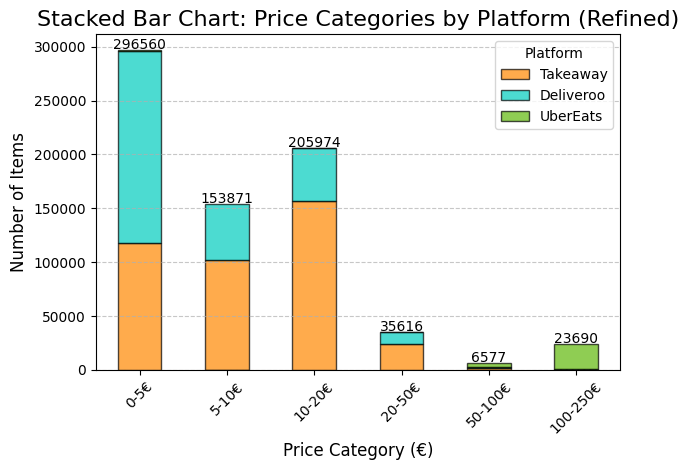

In [28]:

# Paths to databases
databases = {
    "Takeaway": "../databases/takeaway.db",
    "Deliveroo": "../databases/deliveroo.db",
    "UberEats": "../databases/ubereats.db"
}

def fetch_prices(db_path, table_name="menuItems", price_column="price"):
    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            query = f"SELECT {price_column} FROM {table_name} WHERE CAST({price_column} AS REAL) >= 0;"
            cursor.execute(query)
            prices = [float(row[0]) for row in cursor.fetchall() if row[0] is not None]
        return prices
    except Exception as e:
        print(f"Error fetching data from {db_path}: {e}")
        return []

# Fetch prices for each platform
filtered_takeaway_prices = fetch_prices(databases["Takeaway"], "menuItems", "price")
filtered_deliveroo_prices = fetch_prices(databases["Deliveroo"], "menu_items", "price")
filtered_ubereats_prices = fetch_prices(databases["UberEats"], "menu_items", "price")

# Define updated price categories
bins = [0, 5, 10, 20, 50, 100, 250]
labels = ['0-5€', '5-10€', '10-20€', '20-50€', '50-100€', '100-250€']

# Recreate binned data for each platform with updated bins
takeaway_binned = pd.cut(filtered_takeaway_prices, bins=bins, labels=labels, right=False)
deliveroo_binned = pd.cut(filtered_deliveroo_prices, bins=bins, labels=labels, right=False)
ubereats_binned = pd.cut(filtered_ubereats_prices, bins=bins, labels=labels, right=False)

# Count occurrences in each bin
takeaway_counts = takeaway_binned.value_counts()
deliveroo_counts = deliveroo_binned.value_counts()
ubereats_counts = ubereats_binned.value_counts()

# Ensure counts are in the same order as labels
takeaway_counts = takeaway_counts.reindex(labels, fill_value=0)
deliveroo_counts = deliveroo_counts.reindex(labels, fill_value=0)
ubereats_counts = ubereats_counts.reindex(labels, fill_value=0)

# Combine data into a DataFrame
bar_data = pd.DataFrame({
    'Price Category': labels,
    'Takeaway': takeaway_counts.values,
    'Deliveroo': deliveroo_counts.values,
    'UberEats': ubereats_counts.values
})

# Plot the updated stacked bar chart
plt.figure(figsize=(12, 8))
bar_data.set_index('Price Category').plot(kind='bar', stacked=True, color=['#ff8800', '#00cdbe', '#60b80a'], edgecolor='black', alpha=0.7)
plt.title('Stacked Bar Chart: Price Categories by Platform (Refined)', fontsize=16)
plt.xlabel('Price Category (€)', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Platform', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations
for i, row in bar_data.iterrows():
    total = row[1:].sum()
    plt.text(i, total + 1000, str(total), ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()



Distribution of restaurants per location

In [ ]:
# for deliveroo and takeaway
# Read shapefile for Belgium boundaries
takeaway_db = '../databases/takeaway.db'
deliveroo_db ='../databases/deliveroo.db'
ubereats_db ='../databases/ubereats.db'

def query_db(db, sql_query):
    ''' input: db (path to SQLite database), sql_query (str)
        output: pandas DataFrame
    '''
    conn = sqlite3.connect(db)
    with conn:
        res = pd.read_sql_query(sql_query, conn)
    if conn:
        conn.close()
    return res

df = query_db(deliveroo_db, query_deliveroo)
test = gpd.read_file(r"..\assets\geo\gadm41_BEL_2.shp")

# Prepare GeoDataFrame for restaurant locations
geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Initialize the Folium map (centered around Belgium)
m = folium.Map(location=[50.8503, 4.3517], zoom_start=7)  # Centered on Belgium with zoom level 7

# Add Belgium boundary (GeoJSON) to the map
# Convert the GeoDataFrame to GeoJSON and add it as a layer
folium.GeoJson(test.to_crs(epsg=4326)).add_to(m)

# Prepare data for HeatMap: List of [latitude, longitude]
heat_data = [[row['latitude'], row['longitude']] for _, row in geo_df.iterrows()]

# Add HeatMap layer to the map
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Save the map with heatmap to an HTML file
map_path = r"..\assets\geo\restaurants_takeaway.html"
m.save(map_path)

# Open map in browser
webbrowser.open(map_path)


In [ ]:
# for ubereats
df = query_db(ubereats_db, query_ubereats)
print(df)
# Read shapefile for Belgium boundaries
test = gpd.read_file(r"..\assets\geo\gadm41_BEL_2.shp")

# Prepare GeoDataFrame for restaurant locations
geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Initialize the Folium map (centered around Belgium)
m = folium.Map(location=[50.8503, 4.3517], zoom_start=7)  # Centered on Belgium with zoom level 7

# Add Belgium boundary (GeoJSON) to the map
# Convert the GeoDataFrame to GeoJSON and add it as a layer
folium.GeoJson(test.to_crs(epsg=4326)).add_to(m)

# Prepare data for HeatMap: List of [latitude, longitude]
heat_data = [[row['latitude'], row['longitude']] for _, row in geo_df.iterrows()]

# Add HeatMap layer to the map
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Save the map with heatmap to an HTML file
map_path = r"..\assets\geo\restaurants_ubereats.html"
m.save(map_path)

# Open map in browser
webbrowser.open(map_path)


Top 10 pizza restaurants by rating

Map locations offering kapsalons and their average price.

Compare restaurant distributions across UberEats, Deliveroo, and Takeaway. What are some of the market trends?

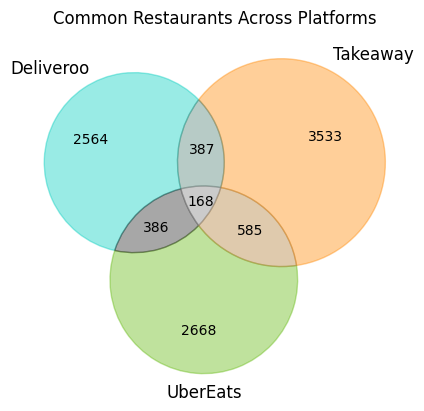

UberEats has the highest number of restaurants, suggesting that UberEats may be the market leader.


In [ ]:

# Query to get restaurant names from each platform's database
# For Deliveroo
query_deliveroo_names = """SELECT name FROM restaurants"""
deliveroo_restaurants = query_db(deliveroo_db, query_deliveroo_names)['name'].unique()

# For Takeaway
query_takeaway_names = """SELECT name FROM restaurants"""
takeaway_restaurants = query_db(takeaway_db, query_takeaway_names)['name'].unique()

# For UberEats
query_ubereats_names = """SELECT title FROM restaurants"""
ubereats_restaurants = query_db(ubereats_db, query_ubereats_names)['title'].unique()
# Convert lists to sets for easy set operations
deliveroo_set = set(deliveroo_restaurants)
takeaway_set = set(takeaway_restaurants)
ubereats_set = set(ubereats_restaurants)

# Find the common restaurants across the platforms
common_deliveroo_takeaway = deliveroo_set.intersection(takeaway_set)
common_deliveroo_ubereats = deliveroo_set.intersection(ubereats_set)
common_takeaway_ubereats = takeaway_set.intersection(ubereats_set)
common_all_three = deliveroo_set.intersection(takeaway_set, ubereats_set)

# Define company colors for each platform
deliveroo_color = '#00cdbe'  # Deliveroo 
takeaway_color = '#ff8800'  # Takeaway 
ubereats_color = '#60b80a'  # UberEats 

# Create the Venn diagram (ensure the sets below are defined)
venn = venn3(subsets=(len(deliveroo_restaurants), len(takeaway_restaurants), len(common_deliveroo_takeaway),
                     len(ubereats_restaurants), len(common_deliveroo_ubereats), len(common_takeaway_ubereats),
                     len(common_all_three)),
             set_labels=('Deliveroo', 'Takeaway', 'UberEats'))

# Set the colors for each region using platform colors
venn.get_patch_by_id('100').set_color(deliveroo_color)  # Deliveroo-only
venn.get_patch_by_id('010').set_color(takeaway_color)  # Takeaway-only
venn.get_patch_by_id('001').set_color(ubereats_color)  # UberEats-only

# Set colors for overlapping regions with custom colors
venn.get_patch_by_id('110').set_color('#4D7F72')  # Deliveroo & Takeaway overlap
venn.get_patch_by_id('011').set_color('#B07C34')  # Takeaway & UberEats overlap
venn.get_patch_by_id('101').set_color('#252525')  # Deliveroo & UberEats overlap
venn.get_patch_by_id('111').set_color('#7D7D7D')  # All three overlap

# Add title to the diagram
plt.title('Common Restaurants Across Platforms')

# Show the plot
plt.show()

# Optional: Display additional analysis
print("UberEats has the highest number of restaurants, suggesting that UberEats may be the market leader.")

#Takeaway has the highest number of restaurants, it suggests that Takeays is likely the market leader.

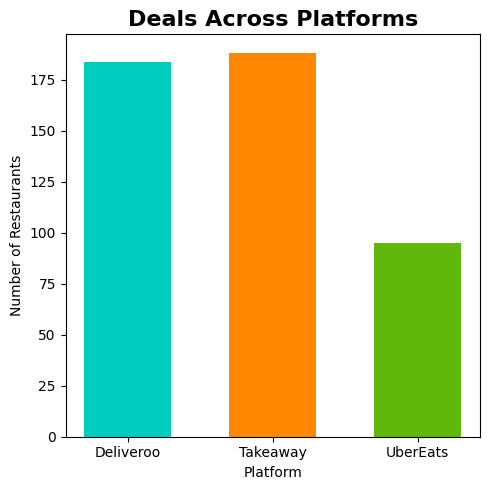

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Query each database and get the counts
deliveroo_count = query_db(deliveroo_db, query_deliveroo_deals).iloc[0, 0]  # Get the first row and first column value
takeaway_count = query_db(takeaway_db, query_takeaway_deals).iloc[0, 0]
ubereats_count = query_db(ubereats_db, query_ubereats_deals).iloc[0, 0]

# Create a DataFrame for the counts
platforms = ['Deliveroo', 'Takeaway', 'UberEats']
counts = [deliveroo_count, takeaway_count, ubereats_count]
count_df = pd.DataFrame({'Platform': platforms, 'Restaurant Count': counts})

# Custom colors
deliveroo_color = '#00cdbe'  # Deliveroo
takeaway_color = '#ff8800'   # Takeaway 
ubereats_color = '#60b80a'   # UberEats 

# Create a list of the colors for each platform
colors = [deliveroo_color, takeaway_color, ubereats_color]

# Plotting the bar chart with custom colors
plt.figure(figsize=(5, 5))
bars = plt.bar(count_df['Platform'], count_df['Restaurant Count'], color=colors, width=0.6)



# Adding labels, title, and grid
plt.xlabel('Platform', fontsize=10)
plt.ylabel('Number of Restaurants', fontsize=10)
plt.title('Deals Across Platforms', fontsize=16, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


# Display the plot with a clean look
plt.tight_layout()  # Ensures the layout is adjusted nicely
plt.show()
